<a href="https://colab.research.google.com/github/nikitaoltyan/ML-Homework/blob/main/Assignment3/Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Задание 2.1 - Нейронные сети

В этом задании вы реализуете и натренируете настоящую нейроную сеть своими руками!

В некотором смысле это будет расширением прошлого задания - нам нужно просто составить несколько линейных классификаторов вместе!

<img src="https://i.redd.it/n9fgba8b0qr01.png" alt="Stack_more_layers" width="400px"/>

In [1]:
# Запустите эту ячейку если работаете в Colab
!git clone https://github.com/nikitaoltyan/ML-Homework.git
%cd ML-Homework/data
! wget -c http://ufldl.stanford.edu/housenumbers/train_32x32.mat http://ufldl.stanford.edu/housenumbers/test_32x32.mat
%cd ../Assignment3

Cloning into 'ML-Homework'...
remote: Enumerating objects: 206, done.
remote: Counting objects: 100% (206/206), done.
remote: Compressing objects: 100% (199/199), done.
remote: Total 206 (delta 79), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (206/206), 1.20 MiB | 12.93 MiB/s, done.
Resolving deltas: 100% (79/79), done.
/content/ML-Homework/data
--2021-03-13 11:46:28--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘train_32x32.mat’

train_32x32.mat     100%[===================>] 173.61M  12.2MB/s    in 15s     

2021-03-13 11:46:43 (11.9 MB/s) - ‘train_32x32.mat’ saved [182040794/182040794]

--2021-03-13 11:46:43--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Reusing existing connection to ufldl.stanford.edu:8

In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [3]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_layer_gradient, check_layer_param_gradient, check_model_gradient
from layers import FullyConnectedLayer, ReLULayer
from model import TwoLayerNet
from trainer import Trainer, Dataset
from optim import SGD, MomentumSGD
from metrics import multiclass_accuracy

# Загружаем данные

И разделяем их на training и validation.

In [4]:
def prepare_for_neural_network(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    return train_flat, test_flat
    
train_X, train_y, test_X, test_y = load_svhn("../data", max_train=10000, max_test=1000)    

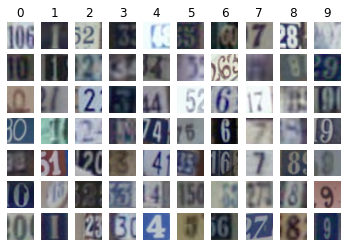

In [5]:
# Перед началом работы полезно посмотреть на данные.
# Отобразим пример из каждого класса.
classes = [str(i) for i in range(10)]
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(train_y == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(train_X[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [6]:
train_X, test_X = prepare_for_neural_network(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Как всегда, начинаем с кирпичиков

Мы будем реализовывать необходимые нам слои по очереди. Каждый слой должен реализовать:
- прямой проход (forward pass), который генерирует выход слоя по входу и запоминает необходимые данные
- обратный проход (backward pass), который получает градиент по выходу слоя и вычисляет градиент по входу и по параметрам

Начнем с ReLU, у которого параметров нет.

In [11]:
# TODO: Implement ReLULayer layer in layers.py
# Note: you'll need to copy implementation of the gradient_check function from the previous assignment

X = np.array([[1,-2,3],
              [-1, 2, 0.1]
              ])

assert check_layer_gradient(ReLULayer(), X)

1.5089402642402123 1.5089402642498582
-0.0 0.0
0.07469286659326062 0.07469286660288788
0.0 0.0
0.2800422610599593 0.2800422610693687
0.25508969643748136 0.2550896964326199
Gradient check passed!


А теперь реализуем полносвязный слой (fully connected layer), у которого будет два массива параметров: W (weights) и B (bias).

Все параметры наши слои будут использовать для параметров специальный класс `Param`, в котором будут храниться значения параметров и градиенты этих параметров, вычисляемые во время обратного прохода.

Это даст возможность аккумулировать (суммировать) градиенты из разных частей функции потерь, например, из cross-entropy loss и regularization loss.

In [16]:
# TODO: Implement FullyConnected layer forward and backward methods
assert check_layer_gradient(FullyConnectedLayer(3, 4), X)
# TODO: Implement storing gradients for W and B
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'W')
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'B')

-0.0033065151497049393 -0.0033065151497022045
-0.00034134404761636554 -0.0003413440476454643
0.0008216095219230818 0.0008216095219535506
0.0020788748481039613 0.0020788748480906477
0.0019659093293318344 0.001965909329337129
-0.00274082470580148 -0.002740824705800386
Gradient check passed!
-2.7864863205043466 -2.786486320504374
-1.2158447225149975 -1.2158447225150102
-1.4368217652324369 -1.4368217652324828
1.589320777657052 1.5893207776571452
5.572972641008693 5.572972641008748
2.431689445029995 2.4316894450300204
2.8736435304648738 2.8736435304648786
-3.178641555314104 -3.1786415553141167
-4.083600021305703 -4.083600021305769
-1.266636455146983 -1.2666364551469458
0.07887541241585098 0.07887541241587831
2.1975169514985113 2.197516951498498
Gradient check passed!
0.9807674491458136 0.9807674491458043
0.04613177765566878 0.04613177765570158
0.6555403691434505 0.6555403691434115
1.4855721976712806 1.4855721976713472
Gradient check passed!


## Создаем нейронную сеть

Теперь мы реализуем простейшую нейронную сеть с двумя полносвязным слоями и нелинейностью ReLU. Реализуйте функцию `compute_loss_and_gradients`, она должна запустить прямой и обратный проход через оба слоя для вычисления градиентов.

Не забудьте реализовать очистку градиентов в начале функции.

In [17]:
# TODO: In model.py, implement compute_loss_and_gradients function
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 0)
loss = model.compute_loss_and_gradients(train_X[:2], train_y[:2])

# TODO Now implement backward pass and aggregate all of the params
check_model_gradient(model, train_X[:2], train_y[:2])

Выходные данные были обрезаны до нескольких последних строк (5000).
0.0 0.0
-0.00011007440552596161 -0.00011007441624855117
3.943609354543012e-05 3.943609883094723e-05
0.0 0.0
-0.00012703261716314366 -0.0001270326066560301
3.3084404548257e-05 3.308440188476425e-05
0.0 0.0
-0.0001526930806305786 -0.0001526930581974284
-1.2495653116583256e-05 -1.2495648959998105e-05
0.0 0.0
-0.00010341126182381034 -0.00010341125733503985
4.014467790004486e-05 4.014468757418399e-05
0.0 0.0
-0.00011688298301298598 -0.00011688296996936741
3.578825489247898e-05 3.5788261243396846e-05
0.0 0.0
-0.00014950023996385733 -0.0001495002344142904
-5.84028511028871e-06 -5.840306016580143e-06
0.0 0.0
-6.405106228534763e-05 -6.40510755545165e-05
4.047050017024715e-05 4.0470471418529996e-05
0.0 0.0
-7.39955715667514e-05 -7.399556523068895e-05
3.8194225653102615e-05 3.8194247764522515e-05
0.0 0.0
-0.00011097875073955905 -0.00011097875951548984
-4.62662351481355e-06 -4.626610206059922e-06
0.0 0.0
9.292965925165353e-06 9.29

True

Теперь добавьте к модели регуляризацию - она должна прибавляться к loss и делать свой вклад в градиенты.

In [18]:
# TODO Now implement l2 regularization in the forward and backward pass
model_with_reg = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 1e1)
loss_with_reg = model_with_reg.compute_loss_and_gradients(train_X[:2], train_y[:2])
assert loss_with_reg > loss and not np.isclose(loss_with_reg, loss), \
    "Loss with regularization (%2.4f) should be higher than without it (%2.4f)!" % (loss, loss_with_reg)

check_model_gradient(model_with_reg, train_X[:2], train_y[:2])

Выходные данные были обрезаны до нескольких последних строк (5000).
0.02102577946748838 0.02102577947304951
0.013671327275342126 0.013671327292463785
0.0030849912637167104 0.0030849912624475446
-0.020355296036633153 -0.02035529602650854
0.03898193578962831 0.03898193579043863
0.024692838244335675 0.024692838240802924
0.0049964004977573985 0.004996400493340047
0.005726293281631885 0.005726293261787418
-0.0021763038614515512 -0.0021763038704492033
0.011949517866252741 0.011949517864096036
-0.0009288250915768075 -0.0009288251057171236
0.006158031422202324 0.006158031418124209
0.008814838089154401 0.008814838103887723
0.048568862976835714 0.048568862975884024
-0.018203668026304017 -0.018203668017413577
0.003190536180301588 0.00319053619080023
0.024554975713972135 0.024554975697199662
0.016533532024404596 0.016533532032347864
0.013610960258905224 0.013610960269971882
0.060184339137950064 0.06018433913457243
0.021758169872948433 0.021758169865826456
-0.012436789379826348 -0.01243678935392011

True

Также реализуем функцию предсказания (вычисления значения) модели на новых данных.

Какое значение точности мы ожидаем увидеть до начала тренировки?

In [23]:
# Finally, implement predict function!

# TODO: Implement predict function
# What would be the value we expect?
multiclass_accuracy(model_with_reg.predict(train_X[:30]), train_y[:30])

0.1

# Допишем код для процесса тренировки

Если все реализовано корректно, значение функции ошибки должно уменьшаться в некоторых эпохах. Не беспокойтесь пока про validation accuracy.

In [24]:
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate = 1e-2)

# TODO Implement missing pieces in Trainer.fit function
# You should expect loss to go down every epoch, even if it's slow
loss_history, train_history, val_history = trainer.fit()

Loss: 2.293287, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302423, Train accuracy: 0.148222, val accuracy: 0.140000
Loss: 2.292855, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.296292, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.311298, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.295913, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301405, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.296104, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.303336, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.293032, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.298665, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.293097, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.300951, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.297740, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.287236, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.298525, Train acc

# Улучшаем процесс тренировки

Мы реализуем несколько ключевых оптимизаций, необходимых для тренировки современных нейросетей.

## Уменьшение скорости обучения (learning rate decay)

Одна из необходимых оптимизаций во время тренировки нейронных сетей - постепенное уменьшение скорости обучения по мере тренировки.

Один из стандартных методов - уменьшение скорости обучения (learning rate) каждые N эпох на коэффициент d (часто называемый decay). Значения N и d, как всегда, являются гиперпараметрами и должны подбираться на основе эффективности на проверочных данных (validation data). 

В нашем случае N будет равным 1.

In [39]:
# TODO Implement learning rate decay inside Trainer.fit method
# Decay should happen once per epoch

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate_decay=0.99)

initial_learning_rate = trainer.learning_rate
loss_history, train_history, val_history = trainer.fit()

print(initial_learning_rate, trainer.learning_rate)
assert trainer.learning_rate < initial_learning_rate, "Learning rate should've been reduced"
assert trainer.learning_rate > 0.5*initial_learning_rate, "Learning rate shouldn'tve been reduced that much!"

Loss: 2.256811, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.228203, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.297693, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.329535, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.292920, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.237087, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.266680, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.235750, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.277592, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.279035, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.259474, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.262558, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.269604, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.242286, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.300169, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.286911, Train acc

# Накопление импульса (Momentum SGD)

Другой большой класс оптимизаций - использование более эффективных методов градиентного спуска. Мы реализуем один из них - накопление импульса (Momentum SGD).

Этот метод хранит скорость движения, использует градиент для ее изменения на каждом шаге, и изменяет веса пропорционально значению скорости.
(Физическая аналогия: Вместо скорости градиенты теперь будут задавать ускорение, но будет присутствовать сила трения.)

```
velocity = momentum * velocity - learning_rate * gradient 
w = w + velocity
```

`momentum` здесь коэффициент затухания, который тоже является гиперпараметром (к счастью, для него часто есть хорошее значение по умолчанию, типичный диапазон -- 0.8-0.99).

Несколько полезных ссылок, где метод разбирается более подробно:  
http://cs231n.github.io/neural-networks-3/#sgd  
https://distill.pub/2017/momentum/

In [36]:
# TODO: Implement MomentumSGD.update function in optim.py

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-4, learning_rate_decay=0.99)

# You should see even better results than before!
loss_history, train_history, val_history = trainer.fit()

Loss: 2.318258, Train accuracy: 0.196667, val accuracy: 0.206000


/content/ML-Homework/Assignment3/layers.py:67: RuntimeWarning: divide by zero encountered in log
  loss = - 1 / N * np.sum(np.log(p_pred))


Loss: inf, Train accuracy: 0.103667, val accuracy: 0.094000
Loss: inf, Train accuracy: 0.146778, val accuracy: 0.172000
Loss: inf, Train accuracy: 0.156000, val accuracy: 0.149000
Loss: 2.255332, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.317853, Train accuracy: 0.162778, val accuracy: 0.155000
Loss: 2.256506, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.318352, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.249076, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.292008, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.312696, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.297965, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.281543, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.260327, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.277593, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.337687, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.371348, Train accuracy: 0.196667

# Ну что, давайте уже тренировать сеть!

## Последний тест - переобучимся (overfit) на маленьком наборе данных

Хороший способ проверить, все ли реализовано корректно - переобучить сеть на маленьком наборе данных.  
Наша модель обладает достаточной мощностью, чтобы приблизить маленький набор данных идеально, поэтому мы ожидаем, что на нем мы быстро дойдем до 100% точности на тренировочном наборе. 

Если этого не происходит, то где-то была допущена ошибка!

In [37]:
data_size = 15
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, num_epochs=150, batch_size=5)

# You should expect this to reach 1.0 training accuracy 
loss_history, train_history, val_history = trainer.fit()

Loss: 2.347621, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.319951, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.307198, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.266939, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.267926, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.315570, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.236251, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.178573, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.180895, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.107211, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.400475, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.087990, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.005478, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 1.883921, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 2.339397, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 1.674047, Train acc

Теперь найдем гипепараметры, для которых этот процесс сходится быстрее.
Если все реализовано корректно, то существуют параметры, при которых процесс сходится в **20** эпох или еще быстрее.
Найдите их!

In [53]:
# Now, tweak some hyper parameters and make it train to 1.0 accuracy in 20 epochs or less

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 20, reg = 1e-2)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
# TODO: Change any hyperparamers or optimizators to reach training accuracy in 20 epochs
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-1, num_epochs=20, batch_size=5)

loss_history, train_history, val_history = trainer.fit()

Loss: 2.309863, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.291273, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.233687, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.167954, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.111013, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.275094, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.127746, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.583065, Train accuracy: 0.466667, val accuracy: 0.133333
Loss: 1.771766, Train accuracy: 0.533333, val accuracy: 0.000000
Loss: 0.756617, Train accuracy: 0.600000, val accuracy: 0.000000
Loss: 1.565106, Train accuracy: 0.533333, val accuracy: 0.000000
Loss: 1.684725, Train accuracy: 0.666667, val accuracy: 0.000000
Loss: 0.821441, Train accuracy: 0.800000, val accuracy: 0.000000
Loss: 1.446334, Train accuracy: 0.800000, val accuracy: 0.000000
Loss: 0.390885, Train accuracy: 0.866667, val accuracy: 0.066667
Loss: 0.892728, Train acc

# Итак, основное мероприятие!

Натренируйте лучшую нейросеть! Можно добавлять и изменять параметры, менять количество нейронов в слоях сети и как угодно экспериментировать. 

Добейтесь точности лучше **60%** на validation set.

In [59]:
# Let's train the best one-hidden-layer network we can

learning_rate = 1e-4
reg_strength = 1e-3
learning_rate_decay = 0.9
hidden_layer_size = 180
num_epochs = 50
batch_size = 80

best_classifier = None
best_val_accuracy = None

loss_history = []
train_history = []
val_history = []

# TODO find the best hyperparameters to train the network
# Don't hesitate to add new values to the arrays above, perform experiments, use any tricks you want
# You should expect to get to at least 40% of valudation accuracy
# Save loss/train/history of the best classifier to the variables above

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = hidden_layer_size, reg = reg_strength)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, MomentumSGD(), num_epochs=num_epochs,
                  batch_size=batch_size, learning_rate=learning_rate, learning_rate_decay = learning_rate_decay)

loss, train, val = trainer.fit()
loss_history.append(loss)
train_history.append(train)
val_history.append(val)
best_val_accuracy = max(val_history)


print('best validation accuracy achieved: %f' % max(best_val_accuracy))
assert max(best_val_accuracy) > 0.6, "Accuracy wasn't achieved"
best_classifier = model


Loss: 2.301030, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.528365, Train accuracy: 0.379889, val accuracy: 0.383000
Loss: 1.734932, Train accuracy: 0.593000, val accuracy: 0.576000
Loss: 1.729173, Train accuracy: 0.663667, val accuracy: 0.640000
Loss: 1.077690, Train accuracy: 0.690222, val accuracy: 0.659000
Loss: 1.302051, Train accuracy: 0.712222, val accuracy: 0.671000
Loss: 1.046790, Train accuracy: 0.745111, val accuracy: 0.695000
Loss: 1.131471, Train accuracy: 0.784889, val accuracy: 0.722000
Loss: 0.845477, Train accuracy: 0.791222, val accuracy: 0.746000
Loss: 0.776453, Train accuracy: 0.809889, val accuracy: 0.736000
Loss: 1.122088, Train accuracy: 0.812222, val accuracy: 0.748000
Loss: 0.952225, Train accuracy: 0.817111, val accuracy: 0.742000
Loss: 0.935463, Train accuracy: 0.823222, val accuracy: 0.730000
Loss: 0.961121, Train accuracy: 0.828111, val accuracy: 0.758000
Loss: 0.804666, Train accuracy: 0.834222, val accuracy: 0.740000
Loss: 1.175219, Train acc

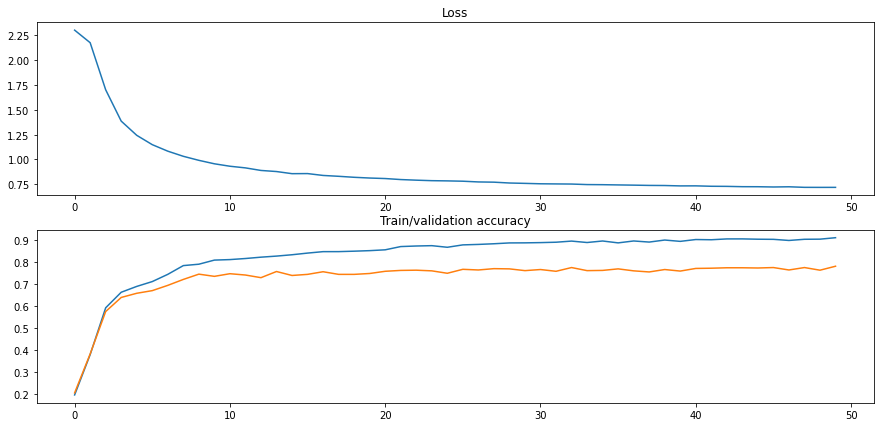

In [62]:
plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.title("Loss")
plt.plot(loss_history[0])
plt.subplot(212)
plt.title("Train/validation accuracy")
plt.plot(train_history[0])
plt.plot(val_history[0])

# Как обычно, посмотрим, как наша лучшая модель работает на тестовых данных

In [63]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Neural net test set accuracy: %f' % (test_accuracy, ))

Neural net test set accuracy: 0.747000
